In [1]:
# include all the imports here
import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pydicom
import random
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, GlobalAveragePooling2D, Input, AveragePooling2D)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from functools import lru_cache
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_labels_path =  'stage_2_train_labels.csv'
class_info_path = 'stage_2_detailed_class_info.csv'

# Load CSV files
train_labels_df = pd.read_csv(train_labels_path)
class_info_df = pd.read_csv(class_info_path)

# Display first few rows of each DataFrame
print("Train Labels DataFrame (First 5 rows):")
print("-" * 80)
print(train_labels_df.head())
print("\n\nClass Info DataFrame (First 5 rows):")
print("-" * 80)
print(class_info_df.head())


# Basic stats about the datasets
print("\nTrain Labels DataFrame Info:")
print("-" * 80)
print(f"Shape: {train_labels_df.shape}")
print(f"Columns: {train_labels_df.columns.tolist()}")

print("\n\nClass Info DataFrame Info:")
print("-" * 80)
print(f"Shape: {class_info_df.shape}")
print(f"Columns: {class_info_df.columns.tolist()}")


# Check for missing values
print("\nMissing values in Train Labels DataFrame:")
print("-" * 80)
print(train_labels_df.isnull().sum())
print("\n\nMissing values in Class Info DataFrame:")
print("-" * 80)
print(class_info_df.isnull().sum())


# Count unique patients
unique_patients_labels = train_labels_df['patientId'].nunique()
unique_patients_class = class_info_df['patientId'].nunique()
print(f"\n\nNumber of unique patients in Train Labels: {unique_patients_labels}")
print("-" * 80)
print(f"Number of unique patients in Class Info: {unique_patients_class}")
print("-" * 80)

#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', train_labels_df.duplicated().sum())
print("-" * 80)

print('Count of Duplicates: ', class_info_df.duplicated().sum())
print("-" * 80)
df_class_info_clean = class_info_df.drop_duplicates()
print("After dropping duplicates:", df_class_info_clean.shape)


Train Labels DataFrame (First 5 rows):
--------------------------------------------------------------------------------
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Class Info DataFrame (First 5 rows):
--------------------------------------------------------------------------------
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-4

In [3]:
# Merge train_labels with class_info to have labels and bounding boxex together
train_data_merged = pd.merge(train_labels_df, df_class_info_clean, on='patientId', how='left')


Class distribution:
 class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


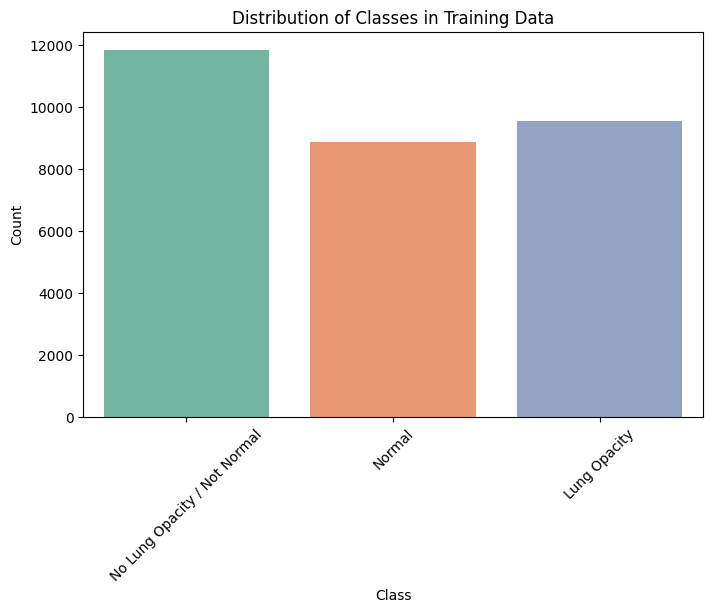

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution count
class_distribution = train_data_merged['class'].value_counts()
print("\nClass distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='Set2', hue='class')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

In [6]:
# Group annotations by patientId clearly
annotations_grouped = train_data_merged.groupby('patientId')

# Example: Display annotations for a specific patient clearly
sample_patient = train_data_merged[train_data_merged['Target'] == 1]['patientId'].iloc[0]

print(f"\nBounding Boxes for patientId '{sample_patient}':")
print(annotations_grouped.get_group(sample_patient))


Bounding Boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
                              patientId      x      y  width  height  Target  \
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

          class  
4  Lung Opacity  
5  Lung Opacity  


In [7]:
# Create dictionary mapping patientId to list of bounding boxes (coordinates)
bbox_dict = {}

for patientId, group in annotations_grouped:
    bboxes = group[['x', 'y', 'width', 'height', 'Target']].values
    bbox_dict[patientId] = bboxes

# Verify clearly
print(f"Bounding boxes for patientId '{sample_patient}':")
print(bbox_dict[sample_patient])

Bounding boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
[[264. 152. 213. 379.   1.]
 [562. 152. 256. 453.   1.]]


In [8]:
# Split DataFrame
train_df, val_df = train_test_split(train_data_merged, test_size=0.2, random_state=42, stratify=train_data_merged['class'])


In [9]:
import os
import pandas as pd
import pydicom
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# === CONFIG ===
DICOM_DIR = 'C://Users//asus//Downloads//stage_2_train_images//stage_2_train_images'
OUTPUT_DIR = './yolo_dataset'
IMAGE_SIZE = (1024, 1024)
CLASS_MAP = {
    'No Lung Opacity / Not Normal': 0,
    'Lung Opacity': 1,
    'Normal': 2
}
VAL_RATIO = 0.2

# === LOAD CSVs ===
labels = pd.read_csv('C://Users//asus//Downloads//stage_2_train_labels.csv')
class_info = pd.read_csv('C://Users//asus//Downloads//stage_2_detailed_class_info.csv')
df = pd.merge(labels, class_info, on='patientId')
df['class_id'] = df['class'].map(CLASS_MAP)

# === GET IMAGE LIST ===
all_ids = df['patientId'].unique()
train_ids, val_ids = train_test_split(all_ids, test_size=VAL_RATIO, random_state=42)

# === UTILS ===
def convert_dicom_to_jpg(dcm_path, jpg_path):
    dcm = pydicom.dcmread(dcm_path)
    img_array = dcm.pixel_array
    img = Image.fromarray(img_array).convert("L")
    img = img.resize(IMAGE_SIZE)
    img.save(jpg_path)

def convert_annotations(df_rows, img_w, img_h):
    yolo_lines = []
    for _, row in df_rows.iterrows():
        # Only process rows with valid bounding box (Target == 1 and no NaN)
        if row['Target'] == 1 and not pd.isnull(row['x']) and not pd.isnull(row['y']) and not pd.isnull(row['width']) and not pd.isnull(row['height']):
            x_center = (row['x'] + row['width'] / 2) / img_w
            y_center = (row['y'] + row['height'] / 2) / img_h
            w = row['width'] / img_w
            h = row['height'] / img_h
            yolo_lines.append(f"{int(row['class_id'])} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")
    return yolo_lines

def process_subset(ids, subset):
    img_out = os.path.join(OUTPUT_DIR, 'images', subset)
    lbl_out = os.path.join(OUTPUT_DIR, 'labels', subset)
    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    for pid in ids:
        dcm_path = os.path.join(DICOM_DIR, pid + '.dcm')
        jpg_path = os.path.join(img_out, pid + '.jpg')
        txt_path = os.path.join(lbl_out, pid + '.txt')

        try:
            convert_dicom_to_jpg(dcm_path, jpg_path)
            img_w, img_h = IMAGE_SIZE
            rows = df[df['patientId'] == pid]
            yolo_lines = convert_annotations(rows, img_w, img_h)
            # Always write the label file (empty if no boxes)
            with open(txt_path, 'w') as f:
                f.write('\n'.join(yolo_lines))
        except Exception as e:
            print(f"Error processing {pid}: {e}")

# === PROCESS DATA ===
print("Processing training set...")
process_subset(train_ids, 'train')
print("Processing validation set...")
process_subset(val_ids, 'val')

Processing training set...
Processing validation set...


In [10]:
import yaml

OUTPUT_DIR = './yolo_dataset'  
CLASS_MAP = {
    'No Lung Opacity / Not Normal': 0,
    'Lung Opacity': 1,
    'Normal': 2
}
# Define the dataset.yaml content
dataset_yaml = {
	'train': f'{OUTPUT_DIR}/images/train',
	'val': f'{OUTPUT_DIR}/images/val',
	'nc': len(CLASS_MAP),
	'names': list(CLASS_MAP.keys())
}

# Write to dataset.yaml
with open('dataset.yaml', 'w') as f:
	yaml.dump(dataset_yaml, f, default_flow_style=False)

print("dataset.yaml created successfully.")


dataset.yaml created successfully.


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load a YOLOv8 model (use 'yolov8n.pt', 'yolov8s.pt', etc. or your custom weights)
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(     
    data='dataset.yaml',    # path to your dataset.yaml
    epochs=50,              # number of training epochs
    imgsz=640,              # image size
    batch=32,         # batch size
    name='pneumonia_yolov8n', # experiment name
    workers=4 
)

New https://pypi.org/project/ultralytics/8.3.153 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.147  Python-3.10.16 torch-2.7.0+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pneumonia_yolov8n2, nbs=64, nms=False, opset=None, optimize=

train: Scanning C:\Users\asus\Downloads\yolo_dataset\labels\train.cache... 21347 images, 16564 backgrounds, 0 corrupt: 100%|██████████| 21347/21347 [00:00<?, ?it/s]

train: C:\Users\asus\Downloads\yolo_dataset\images\train\000db696-cf54-4385-b10b-6b16fbb3f985.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\000fe35a-2649-43d4-b027-e67796d412e0.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\001031d9-f904-4a23-b3e5-2c088acd19c6.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\0022073f-cec8-42ec-ab5f-bc2314649235.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\00436515-870c-4b36-a041-de91049b9ab4.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\00704310-78a8-4b38-8475-49f4573b2dbb.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\0087bd3a-55a7-4045-b111-b018fa52d361.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\00a05408-8291-4231-886e-13763e103161.jpg: 2 duplicate labels 

val: Fast image access  (ping: 0.10.0 ms, read: 94.936.3 MB/s, size: 65.7 KB)


c:\Users\asus\anaconda3\envs\py310_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\asus\Downloads\yolo_dataset\labels\val.cache... 5337 images, 4108 backgrounds, 0 corrupt: 100%|██████████| 5337/5337 [00:00<?, ?it/s]

val: C:\Users\asus\Downloads\yolo_dataset\images\val\002cb550-2e31-42f1-a29d-fbc279977e71.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\01cad8d0-45cd-4603-b099-94055d322310.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\02589621-9494-4801-99a8-a4e89c1b525d.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\02cfa7d1-61e0-4d9e-8664-9a7469ccab76.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\031d627f-e6af-4588-8cca-6be8aa1222c7.jpg: 6 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\035789b1-3736-405d-9910-f8f23c62ae9f.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\0361ea80-0215-4bbe-9bca-908ea7c4f8b6.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downloads\yolo_dataset\images\val\0444a527-72cf-4bc9-b17f-100cf7acc889.jpg: 2 duplicate labels removed
val: C:\Users\asus\Downl


c:\Users\asus\anaconda3\envs\py310_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\pneumonia_yolov8n2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\pneumonia_yolov8n2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.048      5.367      1.951          4        640: 100%|██████████| 668/668 [1:27:12<00:00,  7.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:56<00:00,  6.39s/it]


                   all       5337       1951      0.182      0.214      0.111      0.034

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.028      2.989      1.888          1        640: 100%|██████████| 668/668 [1:23:03<00:00,  7.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [37:04:25<00:00, 1588.87s/it]     

                   all       5337       1951      0.264       0.19      0.147     0.0488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.104      2.793      1.953          3        640: 100%|██████████| 668/668 [1:25:27<00:00,  7.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:15<00:00,  5.89s/it]

                   all       5337       1951      0.184      0.116     0.0732     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.132      2.737      2.022          2        640: 100%|██████████| 668/668 [1:21:47<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:05<00:00,  5.78s/it]

                   all       5337       1951      0.214      0.177      0.109      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.063      2.629      1.972          0        640: 100%|██████████| 668/668 [1:23:32<00:00,  7.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:23<00:00,  5.99s/it]


                   all       5337       1951      0.304      0.314      0.225     0.0824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.011       2.57      1.928          3        640: 100%|██████████| 668/668 [1:23:44<00:00,  7.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:10<00:00,  5.84s/it]

                   all       5337       1951      0.369      0.314      0.264     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.988      2.521      1.918          0        640: 100%|██████████| 668/668 [1:22:15<00:00,  7.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:51<00:00,  5.61s/it]

                   all       5337       1951       0.31      0.317      0.224     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.974      2.463      1.893          1        640: 100%|██████████| 668/668 [1:20:47<00:00,  7.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:14<00:00,  5.88s/it]

                   all       5337       1951      0.355      0.369      0.286      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.966      2.439      1.867          3        640: 100%|██████████| 668/668 [1:28:26<00:00,  7.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:48<00:00,  6.29s/it]

                   all       5337       1951      0.337      0.318      0.243      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.938      2.387      1.866          1        640: 100%|██████████| 668/668 [1:31:59<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:12<00:00,  5.86s/it]

                   all       5337       1951      0.382      0.388      0.295      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.934       2.41      1.851          2        640: 100%|██████████| 668/668 [1:25:24<00:00,  7.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:27<00:00,  6.04s/it]

                   all       5337       1951      0.284     0.0999      0.104      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.914       2.38      1.834          3        640: 100%|██████████| 668/668 [1:23:40<00:00,  7.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:04<00:00,  5.77s/it]

                   all       5337       1951      0.355      0.381      0.305      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.908       2.38      1.826          0        640: 100%|██████████| 668/668 [1:23:31<00:00,  7.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:13<00:00,  5.88s/it]

                   all       5337       1951      0.402       0.37      0.324      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.894      2.346      1.818          2        640: 100%|██████████| 668/668 [1:23:14<00:00,  7.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:14<00:00,  5.88s/it]

                   all       5337       1951      0.361      0.385      0.304      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.891      2.347      1.812          0        640: 100%|██████████| 668/668 [1:22:58<00:00,  7.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:02<00:00,  5.74s/it]

                   all       5337       1951      0.301      0.235      0.181     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.867      2.327      1.801          1        640: 100%|██████████| 668/668 [1:44:10<00:00,  9.36s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [11:36<00:00,  8.29s/it]


                   all       5337       1951      0.338      0.342      0.266     0.0992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.888      2.294      1.803          1        640: 100%|██████████| 668/668 [2:11:34<00:00, 11.82s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:18<00:00,  5.22s/it]

                   all       5337       1951      0.386      0.371      0.325      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G       1.87      2.316      1.793          0        640: 100%|██████████| 668/668 [1:15:01<00:00,  6.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:19<00:00,  5.23s/it]

                   all       5337       1951       0.41      0.404      0.345       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.854      2.298      1.795          4        640: 100%|██████████| 668/668 [1:15:11<00:00,  6.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:12<00:00,  5.15s/it]

                   all       5337       1951      0.385      0.398      0.333      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.842      2.282      1.775          4        640: 100%|██████████| 668/668 [1:15:00<00:00,  6.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:25<00:00,  5.30s/it]

                   all       5337       1951      0.382      0.411      0.337      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.843      2.287      1.771          0        640: 100%|██████████| 668/668 [1:14:58<00:00,  6.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:23<00:00,  5.28s/it]

                   all       5337       1951      0.415      0.393      0.351      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.825      2.235      1.763          0        640: 100%|██████████| 668/668 [1:14:58<00:00,  6.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:27<00:00,  5.33s/it]

                   all       5337       1951        0.4      0.408       0.35      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.827      2.257      1.773          0        640: 100%|██████████| 668/668 [1:16:46<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:24<00:00,  5.30s/it]

                   all       5337       1951       0.39      0.406      0.334      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.819      2.225      1.761          0        640: 100%|██████████| 668/668 [1:22:23<00:00,  7.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:18<00:00,  5.22s/it]

                   all       5337       1951      0.384      0.407      0.338      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.818      2.212      1.759          0        640: 100%|██████████| 668/668 [1:18:40<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:05<00:00,  5.78s/it]

                   all       5337       1951      0.397      0.417       0.36      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.816      2.224      1.765          3        640: 100%|██████████| 668/668 [1:22:22<00:00,  7.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [08:15<00:00,  5.89s/it]

                   all       5337       1951      0.393      0.411      0.354      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.815      2.218      1.742          3        640: 100%|██████████| 668/668 [1:24:58<00:00,  7.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [14:25<00:00, 10.30s/it]

                   all       5337       1951      0.388      0.404      0.349      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.801       2.21      1.741          2        640: 100%|██████████| 668/668 [1:42:14<00:00,  9.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:39<00:00,  5.47s/it]

                   all       5337       1951      0.393      0.417      0.353      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.784       2.21      1.731          2        640: 100%|██████████| 668/668 [1:19:23<00:00,  7.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:37<00:00,  5.44s/it]

                   all       5337       1951      0.404      0.409      0.356      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G       1.79       2.21       1.73          2        640: 100%|██████████| 668/668 [1:52:25<00:00, 10.10s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:40<00:00,  5.48s/it]

                   all       5337       1951      0.383      0.425      0.355      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.783      2.189       1.72          2        640: 100%|██████████| 668/668 [1:42:59<00:00,  9.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [15:06<00:00, 10.79s/it]


                   all       5337       1951      0.392      0.431      0.363      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.788      2.184      1.741          4        640: 100%|██████████| 668/668 [2:24:18<00:00, 12.96s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [16:22<00:00, 11.70s/it]

                   all       5337       1951      0.401       0.42      0.366      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.773      2.166      1.722          1        640: 100%|██████████| 668/668 [1:27:26<00:00,  7.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:54<00:00,  4.93s/it]

                   all       5337       1951        0.4      0.427      0.367      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.757       2.15      1.703          2        640: 100%|██████████| 668/668 [1:11:30<00:00,  6.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:55<00:00,  4.94s/it]

                   all       5337       1951      0.397      0.435       0.37      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G       1.76       2.16      1.702          0        640: 100%|██████████| 668/668 [1:11:41<00:00,  6.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:14<00:00,  5.17s/it]

                   all       5337       1951      0.404      0.419      0.368      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.765      2.137      1.712          1        640: 100%|██████████| 668/668 [1:13:07<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:05<00:00,  5.06s/it]

                   all       5337       1951      0.399      0.422      0.367      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.755      2.139      1.705          2        640: 100%|██████████| 668/668 [1:14:05<00:00,  6.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:08<00:00,  5.10s/it]

                   all       5337       1951      0.391      0.431      0.364      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.736       2.13      1.678          4        640: 100%|██████████| 668/668 [1:20:32<00:00,  7.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:58<00:00,  5.69s/it]

                   all       5337       1951      0.391       0.43      0.369      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.739      2.135      1.695          0        640: 100%|██████████| 668/668 [1:18:07<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:11<00:00,  4.42s/it]

                   all       5337       1951      0.393       0.43      0.368      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50         0G      1.732      2.103      1.686          3        640: 100%|██████████| 668/668 [1:05:12<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:19<00:00,  4.52s/it]

                   all       5337       1951      0.393      0.426      0.366      0.156


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\asus\anaconda3\envs\py310_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      41/50         0G      1.816      2.067      1.792          0        640: 100%|██████████| 668/668 [1:06:23<00:00,  5.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:16<00:00,  4.49s/it]

                   all       5337       1951      0.388      0.424      0.364      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.795      2.046      1.788          5        640: 100%|██████████| 668/668 [1:08:26<00:00,  6.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [07:16<00:00,  5.20s/it]

                   all       5337       1951      0.388      0.424      0.362      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      43/50         0G      1.784      2.036       1.77          2        640: 100%|██████████| 668/668 [1:04:48<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:18<00:00,  4.51s/it]

                   all       5337       1951       0.39      0.419      0.364      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.768      2.058      1.772          0        640: 100%|██████████| 668/668 [1:04:11<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:22<00:00,  4.55s/it]

                   all       5337       1951      0.387       0.42      0.364      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      45/50         0G       1.77      2.005      1.762          0        640: 100%|██████████| 668/668 [1:03:53<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:19<00:00,  4.52s/it]

                   all       5337       1951      0.387       0.42      0.364      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      46/50         0G      1.754      1.998      1.752          4        640: 100%|██████████| 668/668 [1:04:22<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:16<00:00,  4.48s/it]

                   all       5337       1951      0.389       0.42      0.364      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.753      1.972      1.751          2        640: 100%|██████████| 668/668 [1:04:26<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:15<00:00,  4.47s/it]

                   all       5337       1951      0.391      0.419      0.364      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      48/50         0G      1.741      1.968      1.743          2        640: 100%|██████████| 668/668 [1:04:18<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:16<00:00,  4.48s/it]

                   all       5337       1951      0.392      0.418      0.364      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.736      1.996      1.734          1        640: 100%|██████████| 668/668 [1:04:03<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [14:01<00:00, 10.02s/it]

                   all       5337       1951      0.393      0.414      0.364      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.726       1.96      1.728          3        640: 100%|██████████| 668/668 [1:23:14<00:00,  7.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [06:29<00:00,  4.63s/it]

                   all       5337       1951      0.393      0.416      0.364      0.159



50 epochs completed in 111.976 hours.
Optimizer stripped from runs\detect\pneumonia_yolov8n2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\pneumonia_yolov8n2\weights\best.pt, 6.2MB

Validating runs\detect\pneumonia_yolov8n2\weights\best.pt...
Ultralytics 8.3.147  Python-3.10.16 torch-2.7.0+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 84/84 [05:43<00:00,  4.09s/it]


                   all       5337       1951      0.393      0.416      0.364      0.159
          Lung Opacity       1229       1951      0.393      0.416      0.364      0.159
Speed: 1.7ms preprocess, 55.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\pneumonia_yolov8n2


In [5]:
from ultralytics import YOLO

# Load your best model
model = YOLO('C:/Users/asus/Downloads/runs/detect/pneumonia_yolov8n/weights/best.pt')

# Evaluate on the train set
metrics = model.val(data='dataset.yaml', split='train')
print(metrics)

Ultralytics 8.3.147  Python-3.10.16 torch-2.7.0+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 673.5305.5 MB/s, size: 63.6 KB)


val: Scanning C:\Users\asus\Downloads\yolo_dataset\labels\train.cache... 21347 images, 16564 backgrounds, 0 corrupt: 100%|██████████| 21347/21347 [00:00<?, ?it/s]

train: C:\Users\asus\Downloads\yolo_dataset\images\train\000db696-cf54-4385-b10b-6b16fbb3f985.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\000fe35a-2649-43d4-b027-e67796d412e0.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\001031d9-f904-4a23-b3e5-2c088acd19c6.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\0022073f-cec8-42ec-ab5f-bc2314649235.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\00436515-870c-4b36-a041-de91049b9ab4.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\00704310-78a8-4b38-8475-49f4573b2dbb.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\0087bd3a-55a7-4045-b111-b018fa52d361.jpg: 2 duplicate labels removed
train: C:\Users\asus\Downloads\yolo_dataset\images\train\00a05408-8291-4231-886e-13763e103161.jpg: 2 duplicate labels 


c:\Users\asus\anaconda3\envs\py310_env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1335/1335 [17:37<00:00,  1.26it/s]


                   all      21347       7604      0.309       0.32      0.227     0.0805
          Lung Opacity       4783       7604      0.309       0.32      0.227     0.0805
Speed: 0.6ms preprocess, 41.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C000FE0400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.02

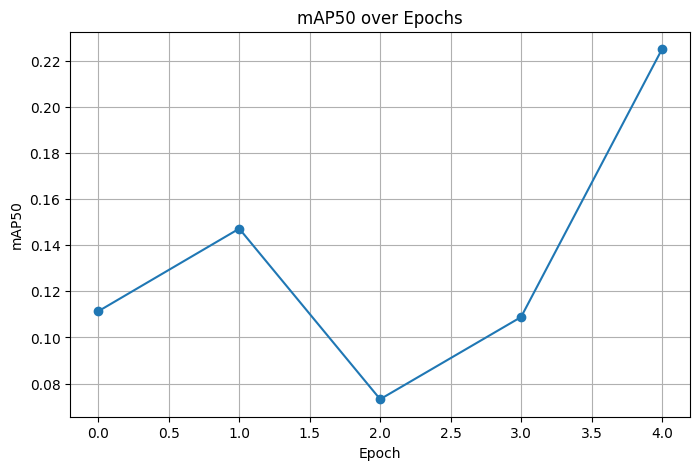

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv file generated by YOLOv8 training
csv_path = 'runs/detect/pneumonia_yolov8n/results.csv'

# Read the CSV file
df = pd.read_csv(csv_path)

# Plot mAP50 over epochs
plt.figure(figsize=(8, 5))
plt.plot(df['metrics/mAP50(B)'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('mAP50')
plt.title('mAP50 over Epochs')
plt.grid(True)
plt.show()


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\002cb550-2e31-42f1-a29d-fbc279977e71.jpg: 640x640 2 Lung Opacitys, 67.7ms
Speed: 3.8ms preprocess, 67.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


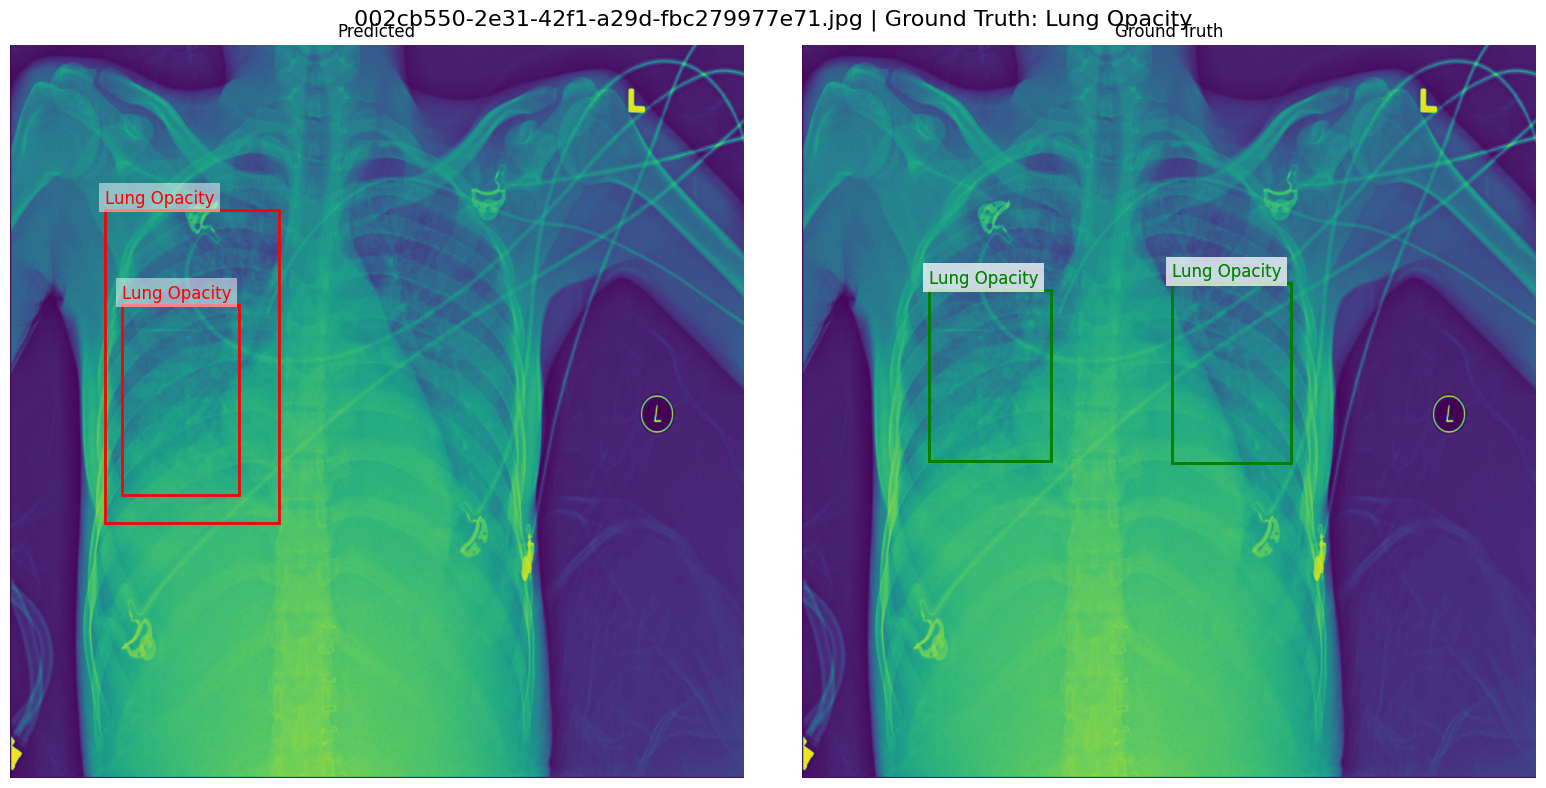


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\0100515c-5204-4f31-98e0-f35e4b00004a.jpg: 640x640 (no detections), 60.7ms
Speed: 3.4ms preprocess, 60.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


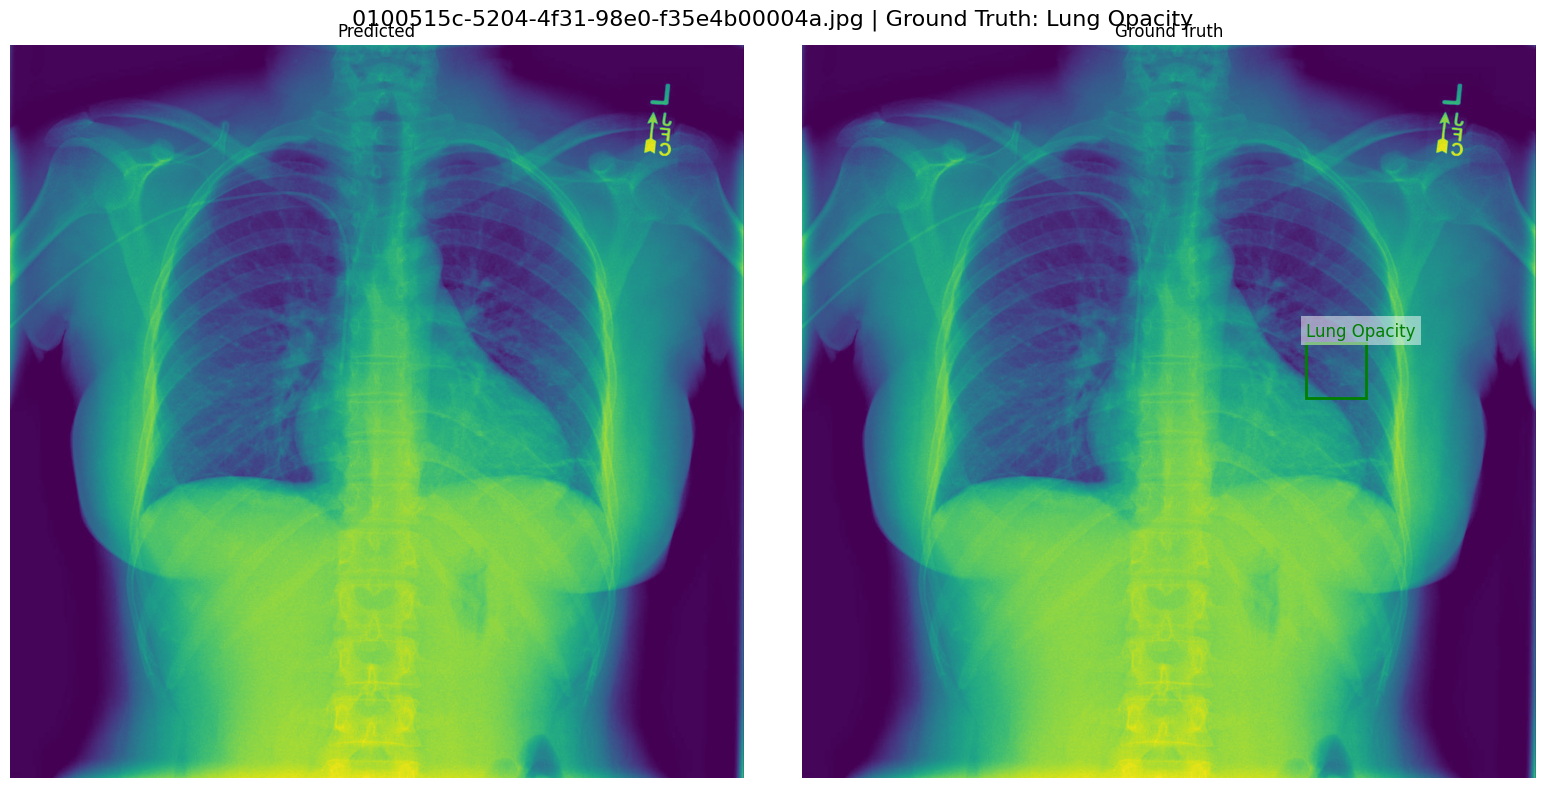


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\01adfd2f-7bc7-4cef-ab68-a0992752b620.jpg: 640x640 3 Lung Opacitys, 62.1ms
Speed: 3.4ms preprocess, 62.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


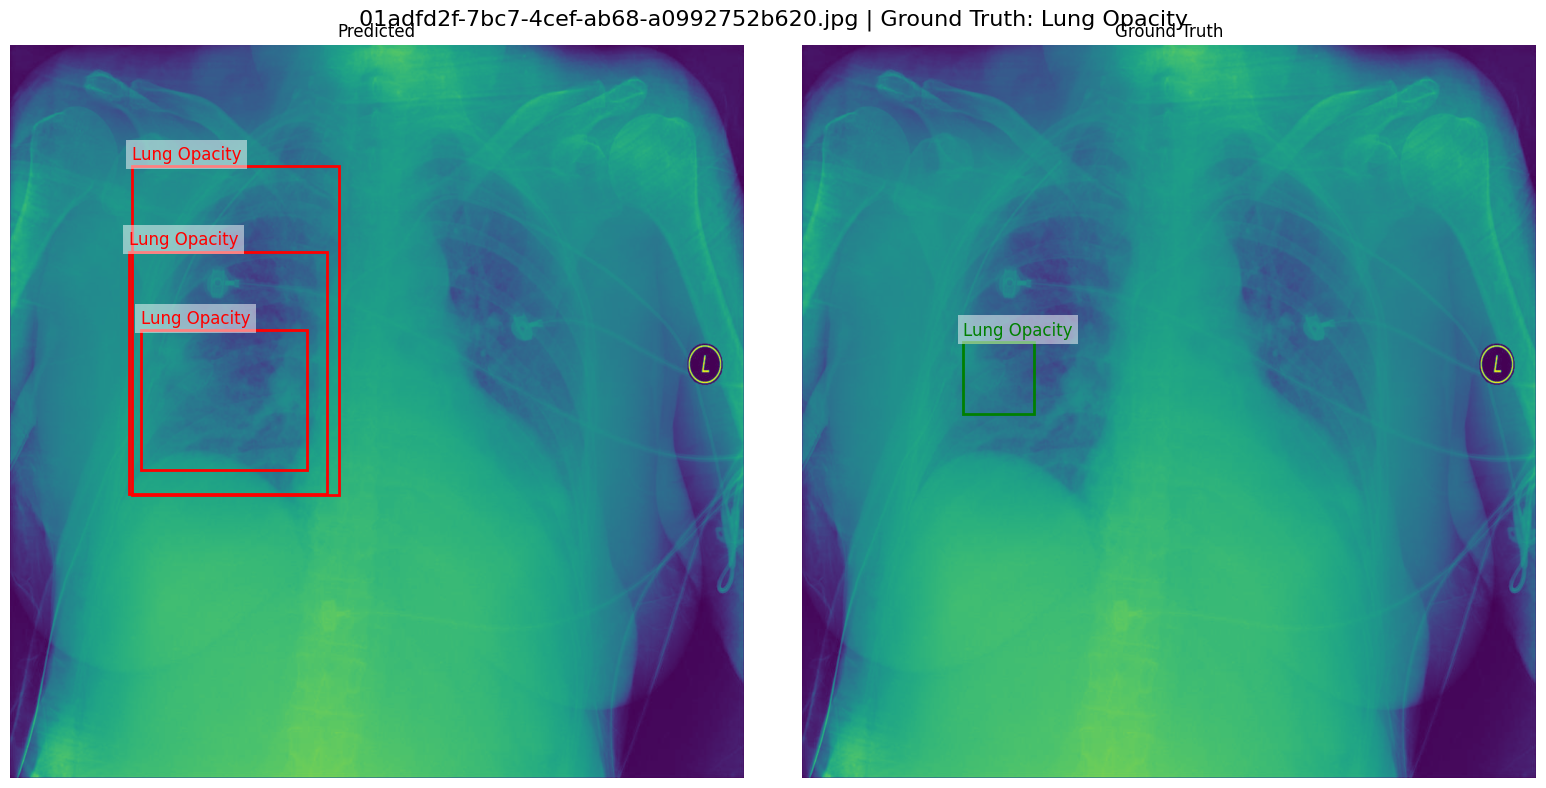


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\01cad8d0-45cd-4603-b099-94055d322310.jpg: 640x640 2 Lung Opacitys, 94.5ms
Speed: 2.8ms preprocess, 94.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


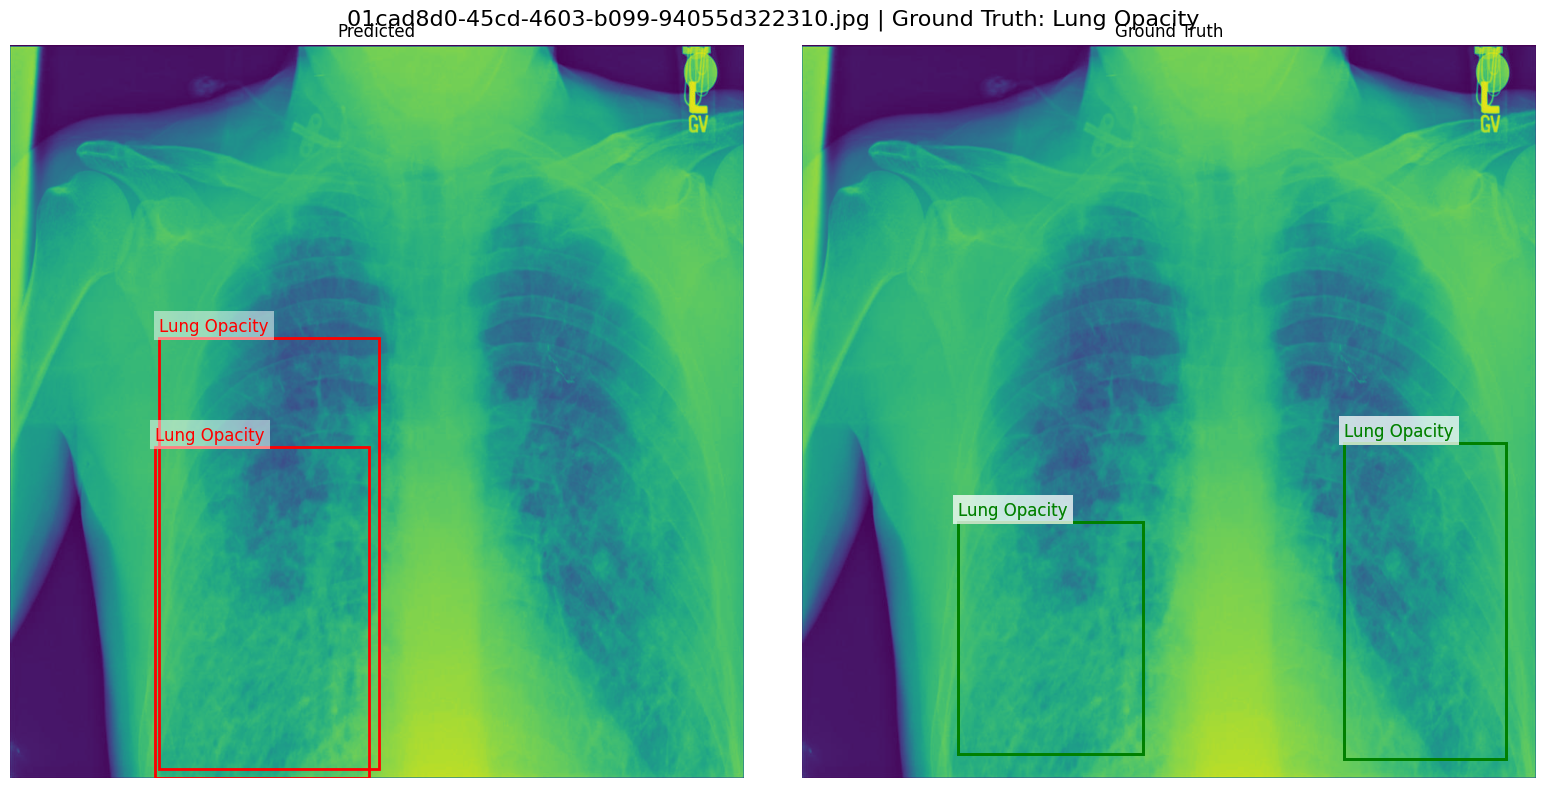


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\01cd2ba5-2baf-44b2-bf15-ee57e1ea4599.jpg: 640x640 (no detections), 62.2ms
Speed: 2.9ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


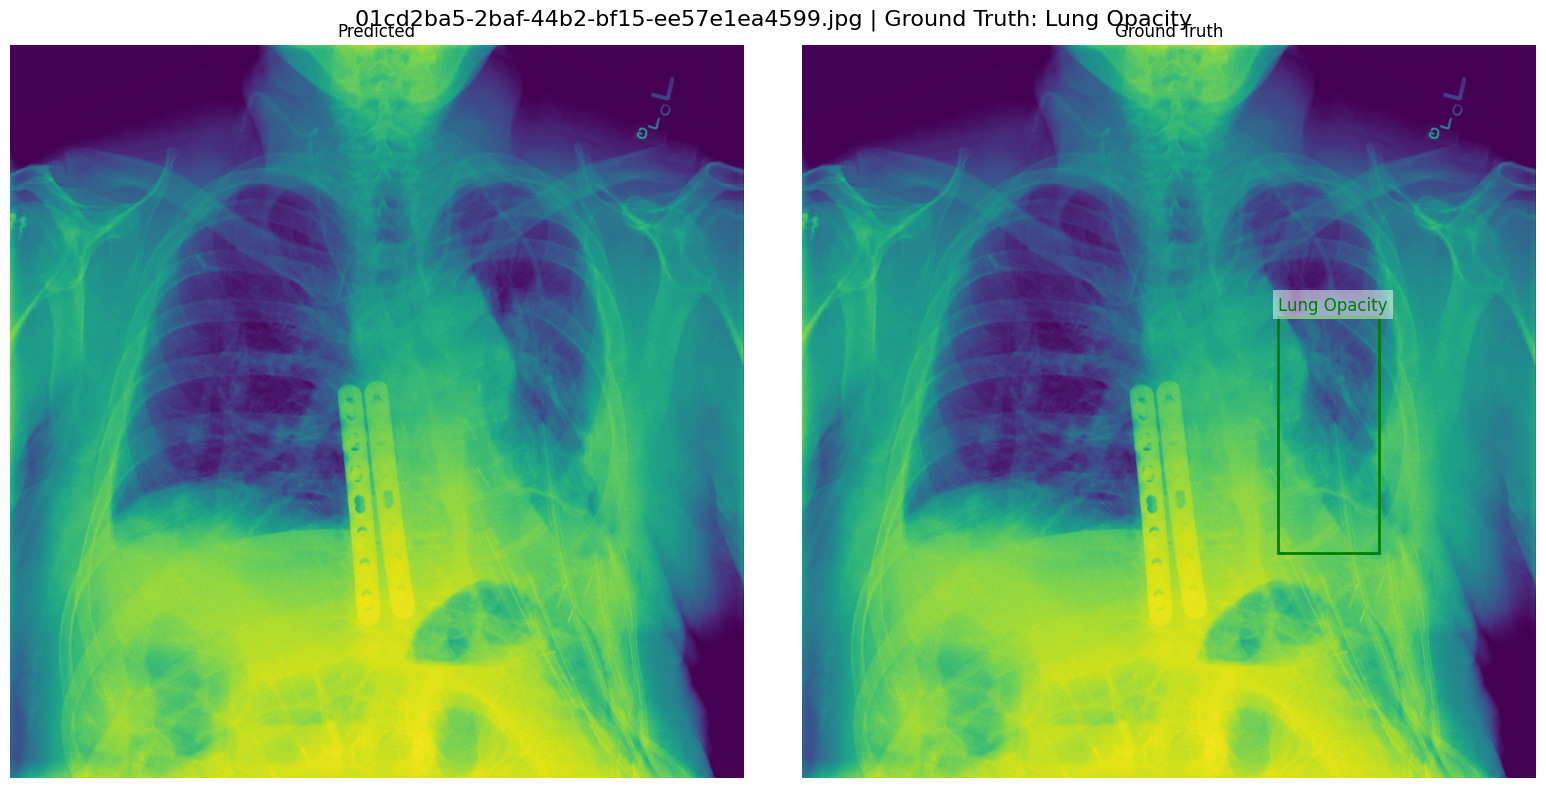


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\02285fa4-35b7-4af6-b88f-3cac45a7f5c8.jpg: 640x640 (no detections), 88.2ms
Speed: 3.1ms preprocess, 88.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


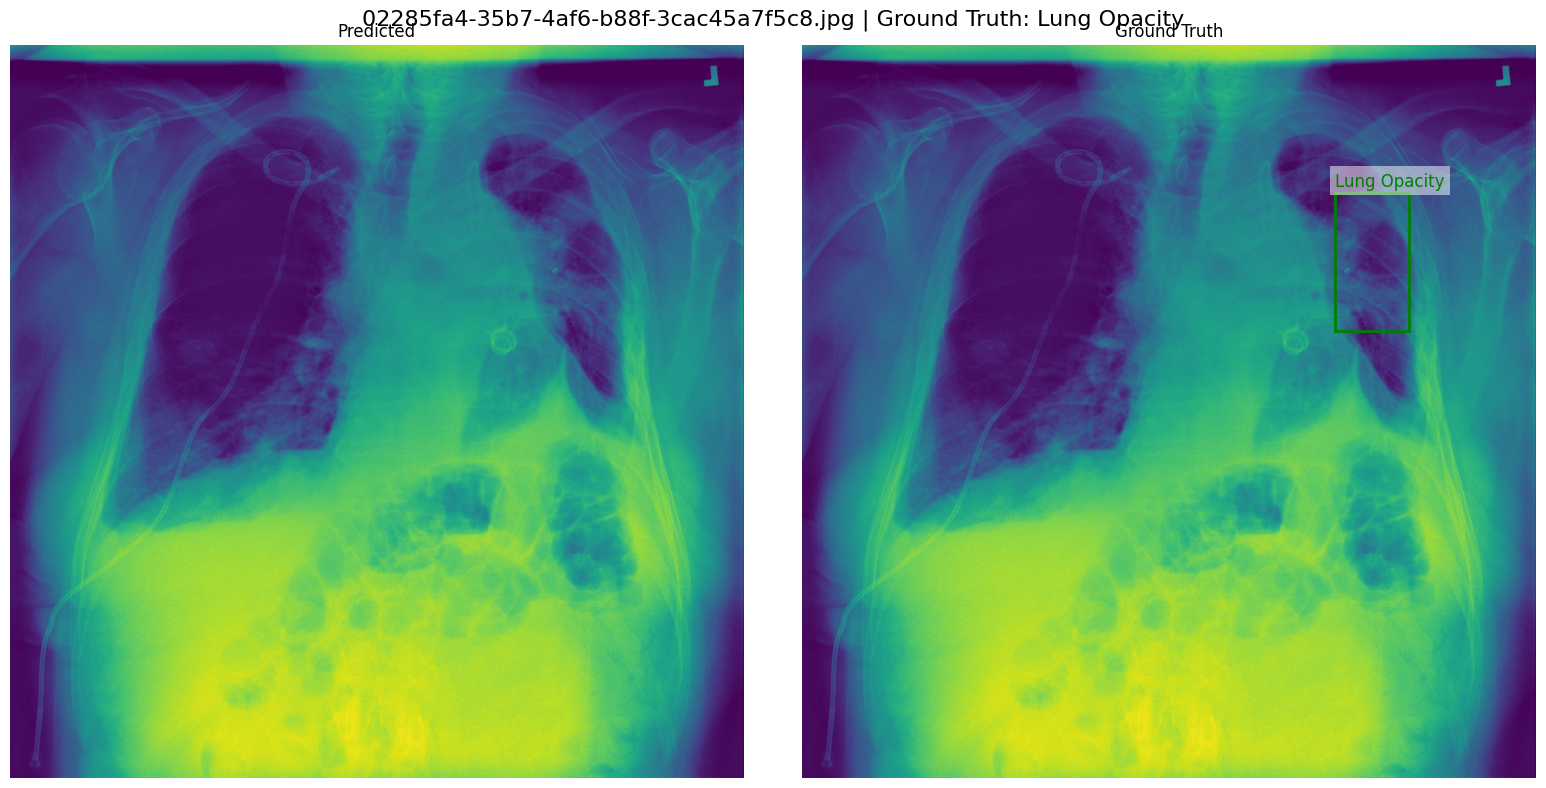


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\02589621-9494-4801-99a8-a4e89c1b525d.jpg: 640x640 6 Lung Opacitys, 66.1ms
Speed: 2.8ms preprocess, 66.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


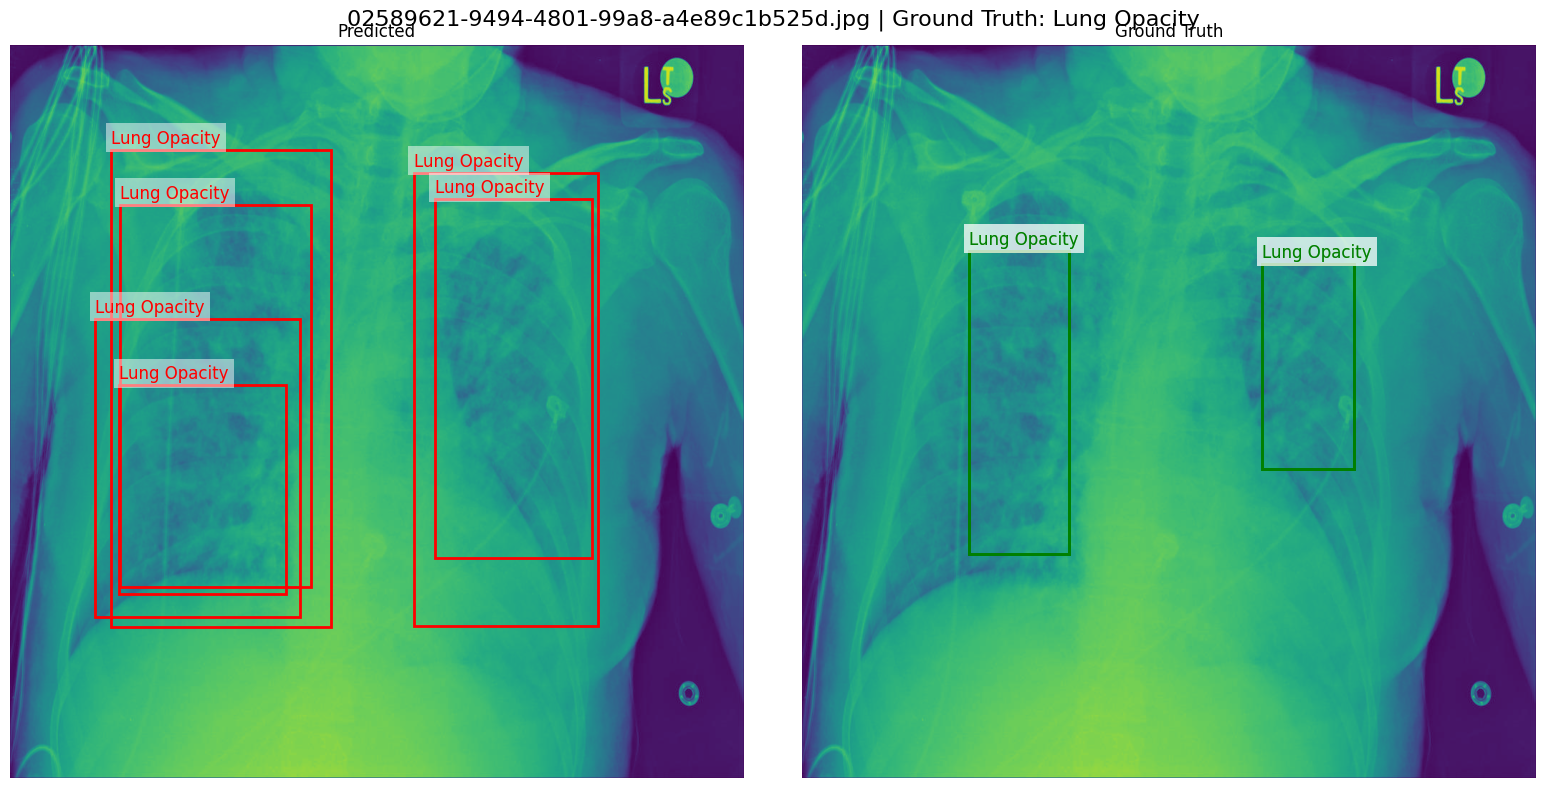


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\025d196b-cfa4-44a5-9e31-0f73dc3b318f.jpg: 640x640 2 Lung Opacitys, 78.8ms
Speed: 3.1ms preprocess, 78.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


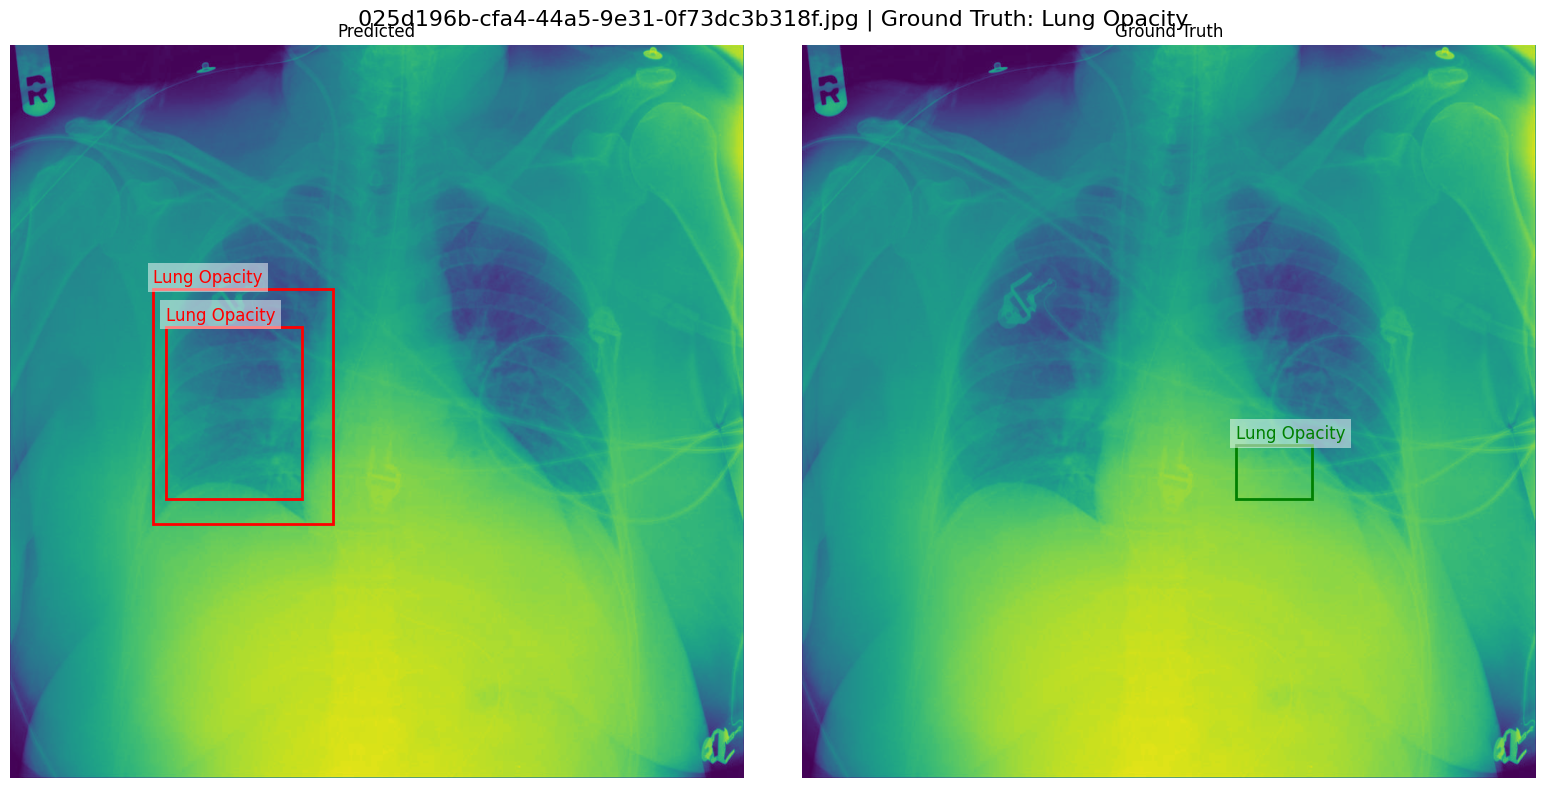


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\02cfa7d1-61e0-4d9e-8664-9a7469ccab76.jpg: 640x640 3 Lung Opacitys, 72.3ms
Speed: 3.0ms preprocess, 72.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


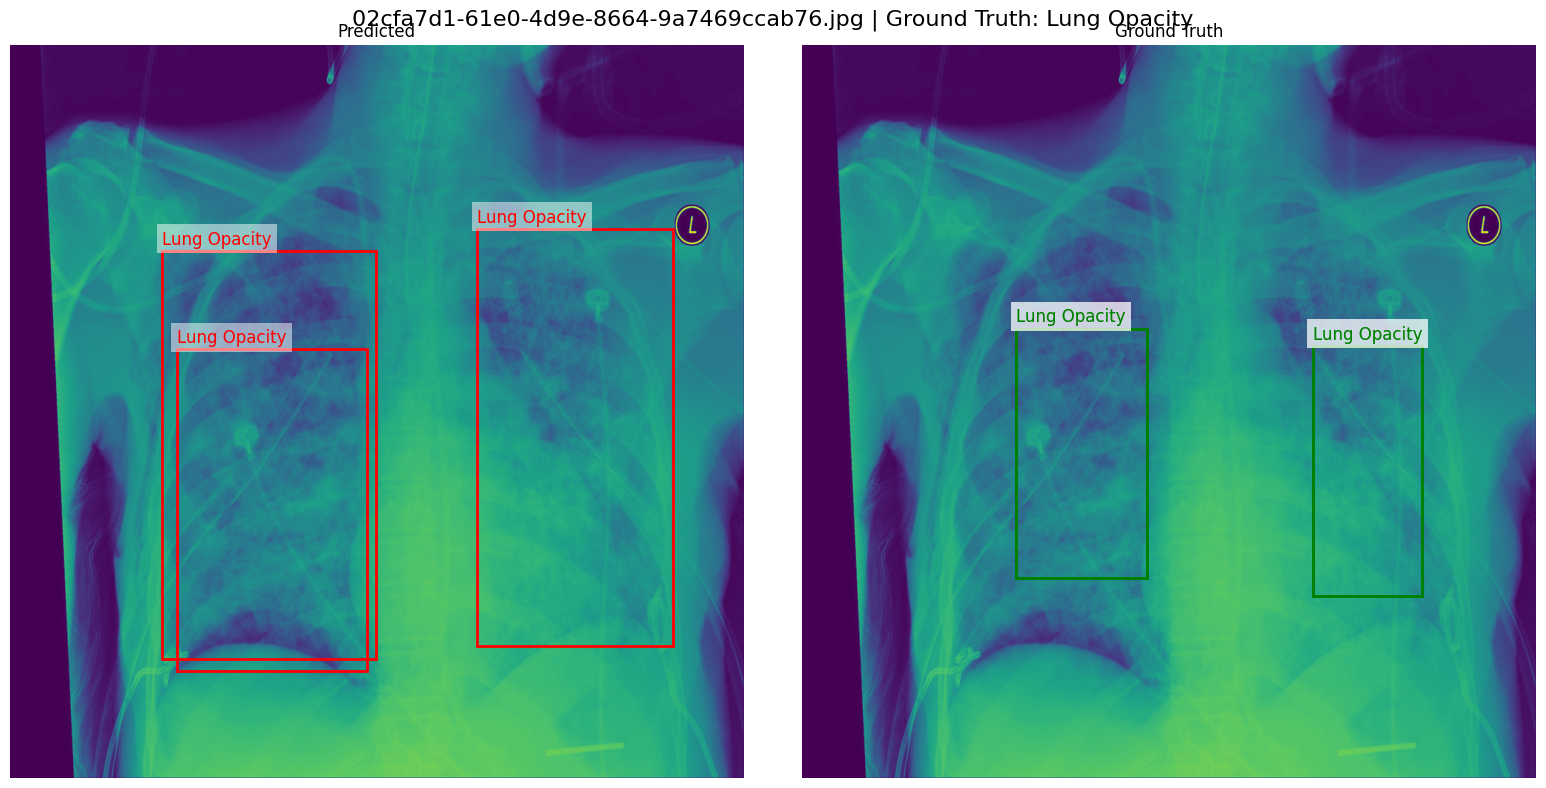


image 1/1 c:\Users\asus\Downloads\yolo_dataset\images\val\031d627f-e6af-4588-8cca-6be8aa1222c7.jpg: 640x640 4 Lung Opacitys, 90.5ms
Speed: 3.0ms preprocess, 90.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


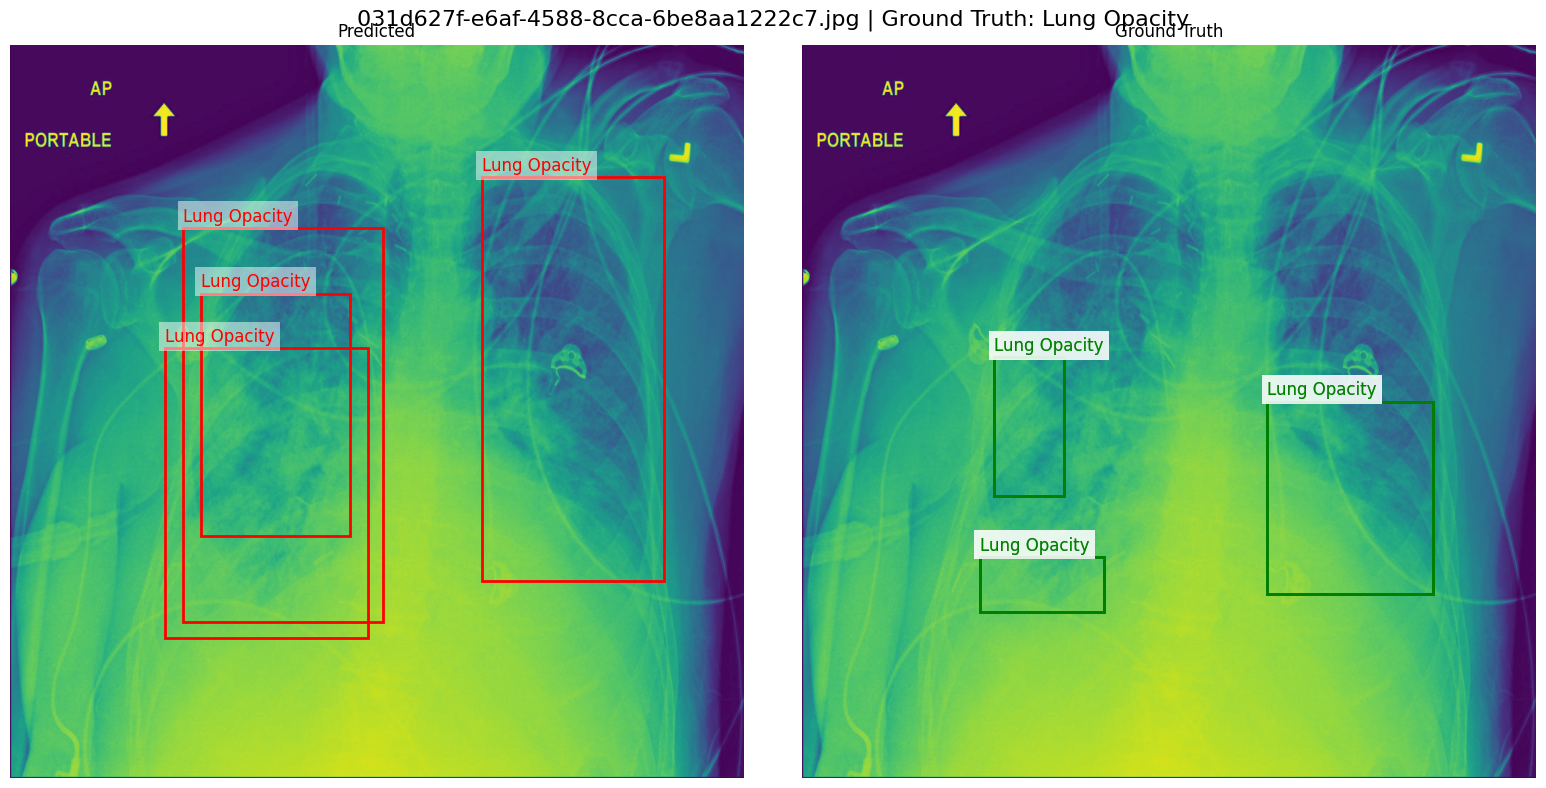

In [7]:
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

output_test_folder = './yolo_dataset/images/val'
label_folder = './yolo_dataset/labels/val'
model_test = YOLO('C:/Users/asus/Downloads/runs/detect/pneumonia_yolov8n/weights/best.pt')

class_names = {0: 'No Lung Opacity / Not Normal', 1: 'Lung Opacity', 2: 'Normal'}
test_images = glob.glob(os.path.join(output_test_folder, '*.jpg'))

lung_opacity_images = []
for img_path in test_images:
    base = os.path.basename(img_path).replace('_pred.jpg', '.txt').replace('.jpg', '.txt')
    label_path = os.path.join(label_folder, base)
    if not os.path.exists(label_path):
        continue
    with open(label_path) as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5 and int(float(parts[0])) == 1:
                lung_opacity_images.append(img_path)
                break  # Only need one box of class 1 to include this image

# Show up to 10 images with Lung Opacity
for img_path in lung_opacity_images[:10]:
    base = os.path.basename(img_path).replace('_pred.jpg', '.txt').replace('.jpg', '.txt')
    label_path = os.path.join(label_folder, base)
    results = model_test(img_path, conf=0.08)  # Lower confidence threshold
    img = Image.open(img_path)

    # Prepare predicted image
    pred_img = img.copy()
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(pred_img)
    axs[0].set_title('Predicted')
    axs[0].axis('off')
    ax_pred = axs[0]

    # Prepare ground truth image
    gt_img = img.copy()
    axs[1].imshow(gt_img)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')
    ax_gt = axs[1]

    # Plot predicted boxes
    for result in results:
        boxes = result.boxes
        if boxes is not None and len(boxes) > 0:
            for box in boxes:
                xyxy = [round(float(x), 2) for x in box.xyxy[0].tolist()]
                pred_cls = int(box.cls[0].item())
                x1, y1, x2, y2 = xyxy
                ax_pred.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
                ax_pred.text(x1, y1-10, f'{model_test.names[pred_cls]}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Plot ground truth boxes
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    gt_cls, x, y, w, h = map(float, parts)
                    img_w, img_h = img.size
                    x1 = int((x - w/2) * img_w)
                    y1 = int((y - h/2) * img_h)
                    x2 = int((x + w/2) * img_w)
                    y2 = int((y + h/2) * img_h)
                    ax_gt.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2))
                    ax_gt.text(x1, y1-10, f'{class_names[int(gt_cls)]}', color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.suptitle(f"{os.path.basename(img_path)} | Ground Truth: Lung Opacity", fontsize=16)
    plt.tight_layout()
    plt.show()